
# Step 1 set global variable



In [1]:

################ GLOBAL VARIABLES ############
DATA_DIR = '/mnt/disks/space/FGVC6/'
ROOT_DIR = '/mnt/disks/space/kaggle-imaterialist/MaskRCNN_approach/'

MODEL_TYPE = 'resnet50'
NUM_CATS = 46
IMAGE_SIZE = 512 #INPUT IMAGE SIZE : IMAGE_SIZE * IMAGE_SIZE

GPU_NUM = 4
IMAGES_PER_GPU_PER_IT = 4 

STEPS_PER_EPOCH_NUM = 40000
VALIDATION_STEPS_NUM = 1000
## input dataset 
label_file = DATA_DIR+"/label_descriptions.json"
train_file = DATA_DIR+"train.csv"


LR = 1e-4
#EPOCHS = [2, 4, 8, 16, 32, 64]
EPOCHS = [2, 4, 8, 9, 10, 11]

## pretrain data
COCO_WEIGHTS_PATH = ROOT_DIR +'Mask_RCNN/mask_rcnn_coco.h5'
RESNET50_IT_08_WEIGHTS = ROOT_DIR +"/fashion_50gpu20190712T0242/mask_rcnn_fashion_50gpu_0008.h5"

###############################################


# Step 2 import libraries

In [2]:

import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

sys.path.append(ROOT_DIR+'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from tensorflow.contrib.tensorboard.plugins import projector


import warnings 
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:

"""
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'   #指定第一块GPU可用
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5  # 程序最多只能占用指定gpu50%的显存
config.gpu_options.allow_growth = True      #程序按需申请内存
sess = tf.Session(config = config)
# 设置session

import keras.backend.tensorflow_backend as KTF
KTF.set_session(sess )
"""

'\nimport tensorflow as tf\nimport os\nos.environ["CUDA_VISIBLE_DEVICES"] = \'0\'   #指定第一块GPU可用\nconfig = tf.ConfigProto()\n#config.gpu_options.per_process_gpu_memory_fraction = 0.5  # 程序最多只能占用指定gpu50%的显存\nconfig.gpu_options.allow_growth = True      #程序按需申请内存\nsess = tf.Session(config = config)\n# 设置session\n\nimport keras.backend.tensorflow_backend as KTF\nKTF.set_session(sess )\n'

# set Mask R-CNN  hyperparameters

In [4]:


class ShopeeConfig(Config):
    
    def __init__(self, class_num, config_name="fashion_shopee"):
        self.NUM_CLASSES = class_num + 1 # +1 for the background class
        self.NAME = config_name
        super().__init__()
        
    
    GPU_COUNT = GPU_NUM
    IMAGES_PER_GPU = IMAGES_PER_GPU_PER_IT 

    BACKBONE = MODEL_TYPE
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = STEPS_PER_EPOCH_NUM
    VALIDATION_STEPS = VALIDATION_STEPS_NUM

    
config = ShopeeConfig(NUM_CATS)
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      4
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

# construct dataset

In [5]:
#Make Datasets from input file


with open(label_file) as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]
for i in range(len(label_names)):
    print(i, label_names[i])


0 shirt, blouse
1 top, t-shirt, sweatshirt
2 sweater
3 cardigan
4 jacket
5 vest
6 pants
7 shorts
8 skirt
9 coat
10 dress
11 jumpsuit
12 cape
13 glasses
14 hat
15 headband, head covering, hair accessory
16 tie
17 glove
18 watch
19 belt
20 leg warmer
21 tights, stockings
22 sock
23 shoe
24 bag, wallet
25 scarf
26 umbrella
27 hood
28 collar
29 lapel
30 epaulette
31 sleeve
32 pocket
33 neckline
34 buckle
35 zipper
36 applique
37 bead
38 bow
39 flower
40 fringe
41 ribbon
42 rivet
43 ruffle
44 sequin
45 tassel


In [6]:
segment_df = pd.read_csv(train_file)
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]


In [7]:

print("Total segments: ", len(segment_df))
segment_df.head()
segment_df.info()

Total segments:  333415
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333415 entries, 0 to 333414
Data columns (total 6 columns):
ImageId          333415 non-null object
EncodedPixels    333415 non-null object
Height           333415 non-null int64
Width            333415 non-null int64
ClassId          333415 non-null object
CategoryId       333415 non-null object
dtypes: int64(2), object(4)
memory usage: 15.3+ MB


In [8]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  45625


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [9]:
#Here is the custom function that resizes an image.
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img


#The crucial part is to create a dataset for this task.
class FashionDataset(utils.Dataset):

    def __init__(self, df, classes_label_names):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(classes_label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            #print(row)
            #print(row.name,int(row['Height']), width=int(row['Width']) )
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR+'/train/'+str(row.name)), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if len(info['labels']) > 0 :
            return info['path'], [label_names[int(x)] for x in info['labels']]
        return info['path'], ["UNKNOWN"]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)
    
    
    
dataset = FashionDataset(image_df,label_names)
dataset.prepare()

('/mnt/disks/space/FGVC6//train/fc27f25e9e78b96f8589966f091b2292.jpg', ['sleeve', 'sleeve', 'shorts', 'jacket', 'collar'])


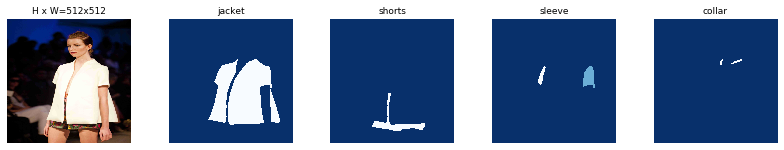

('/mnt/disks/space/FGVC6//train/e3ef88e05f214dedab4290432e6b059e.jpg', ['top, t-shirt, sweatshirt', 'sleeve', 'sleeve', 'neckline'])


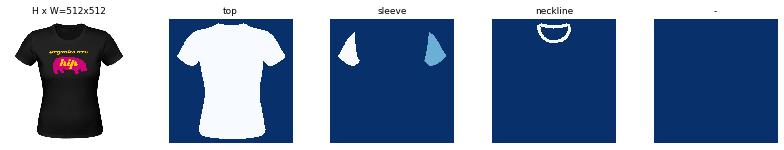

('/mnt/disks/space/FGVC6//train/8e2ddb562182259c3e173cdd4ec15f61.jpg', ['dress', 'neckline'])


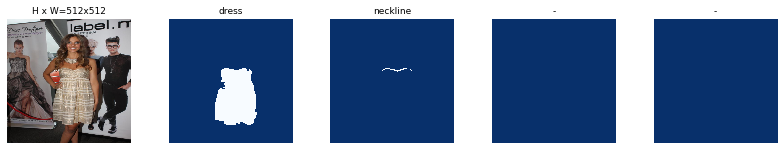

In [10]:
#visualize images and their masks.
for i in range(3):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)


In [11]:
#visualize images and their masks.
"""
n = 0
while n < 30 :
    image_id = random.choice(dataset.image_ids)
    #print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    if 0 in class_ids or 1 in class_ids:
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)
        n += 1
"""

'\nn = 0\nwhile n < 30 :\n    image_id = random.choice(dataset.image_ids)\n    #print(dataset.image_reference(image_id))\n    \n    image = dataset.load_image(image_id)\n    mask, class_ids = dataset.load_mask(image_id)\n    if 0 in class_ids or 1 in class_ids:\n        visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)\n        n += 1\n'

In [12]:

FOLD = 0
N_FOLDS = 5


kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold(splits, train_df):    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return train_df.iloc[train_index], train_df.iloc[valid_index]
        
train_df, valid_df = get_fold(splits, image_df)

train_dataset = FashionDataset(train_df,label_names)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df,label_names)
valid_dataset.prepare()


Total train images:  36500
Total train segments:  267004


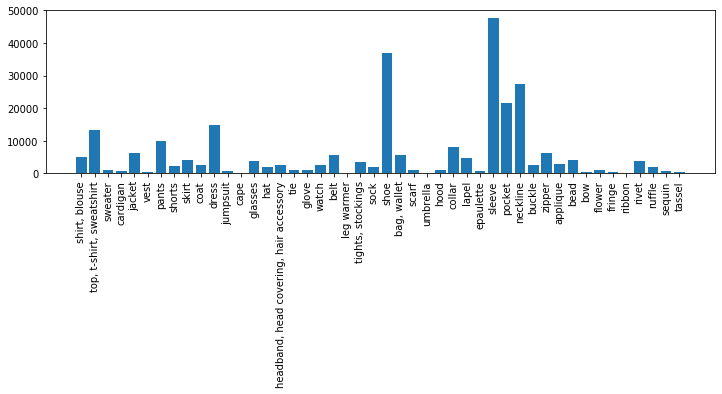

Total train images:  9125
Total validation segments:  66411


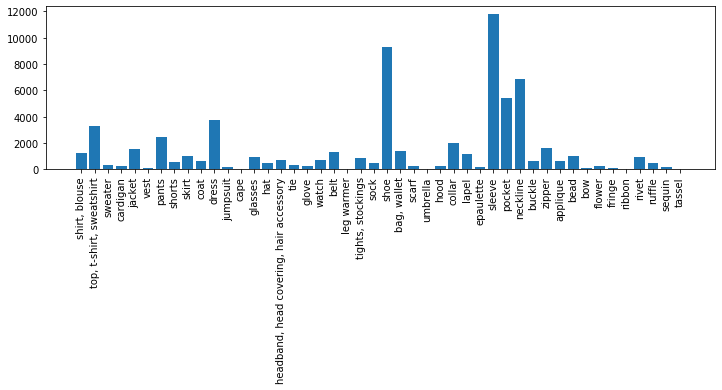

0 shirt, blouse 1232
1 top, t-shirt, sweatshirt 3331
2 sweater 301
3 cardigan 233
4 jacket 1564
5 vest 135
6 pants 2476
7 shorts 570
8 skirt 983
9 coat 621
10 dress 3750
11 jumpsuit 179
12 cape 36
13 glasses 952
14 hat 482
15 headband, head covering, hair accessory 743
16 tie 300
17 glove 269
18 watch 689
19 belt 1332
20 leg warmer 39
21 tights, stockings 832
22 sock 507
23 shoe 9296
24 bag, wallet 1423
25 scarf 260
26 umbrella 14
27 hood 249
28 collar 2043
29 lapel 1193
30 epaulette 177
31 sleeve 11792
32 pocket 5420
33 neckline 6883
34 buckle 625
35 zipper 1604
36 applique 664
37 bead 1026
38 bow 134
39 flower 266
40 fringe 109
41 ribbon 48
42 rivet 933
43 ruffle 457
44 sequin 189
45 tassel 50


In [13]:
#Let's visualize class distributions of the train and validation data.

train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total train images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()
 

for i in range(len(label_names)):
    print(i, label_names[i],  counts[i])

In [14]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
model.load_weights(RESNET50_IT_08_WEIGHTS, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])


Instructions for updating:
Colocations handled automatically by placer.
Re-starting from epoch 8


In [15]:
augmentation = iaa.Sequential([
    # orientation
    iaa.Fliplr(0.5),  
    #iaa.Fliplr(1),
    iaa.Flipud(0.5),
    #iaa.Flipud(1),

    # shape
    iaa.PiecewiseAffine(scale=(0.01, 0.05)),
    #iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.CropAndPad(
        percent=(0, 0.2),
        pad_mode=["constant", "edge"],
        pad_cval=(0, 128)
    ),
    iaa.Affine(rotate=(-45, 45)),
    iaa.Affine(shear=(-16, 16)),
    # noises
    #iaa.ContrastNormalization((0.75, 1.5)),
    #iaa.AdditiveGaussianNoise(scale=0.2*255),
    #iaa.Sharpen(alpha=0.5),
    

    #change color
    #iaa.Superpixels(p_replace=0.5, n_segments=64),
    iaa.Superpixels(p_replace=(0.1, 1.0), n_segments=(16, 128)),
    #iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
    #iaa.WithChannels(0, iaa.Add((50, 100))),
    #iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB"),
    iaa.WithColorspace(
        to_colorspace="HSV",
        from_colorspace="RGB",
        children=iaa.WithChannels(0, iaa.Add((10, 50)))
    ),
], random_order=True) 


In [16]:

"""
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5)
])

augmentation = iaa.Sequential([
    # orientation
    iaa.Fliplr(0.5),  
    iaa.Fliplr(1),
    iaa.Flipud(0.5),
    iaa.Flipud(1),
    iaa.Affine(rotate=(-45, 45)),
    # shape

    iaa.PiecewiseAffine(scale=(0.01, 0.05)),
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.CropAndPad(
        percent=(0, 0.2),
        pad_mode=["constant", "edge"],
        pad_cval=(0, 128)
    ),
    iaa.Affine(rotate=(-45, 45)),
    iaa.Affine(shear=(-16, 16)),
    # noises
    iaa.ContrastNormalization((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(scale=0.2*255),
    iaa.Sharpen(alpha=0.5),
    

    #change color
    iaa.Superpixels(p_replace=0.5, n_segments=64),
    iaa.Superpixels(p_replace=(0.1, 1.0), n_segments=(16, 128)),
    iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
    iaa.WithChannels(0, iaa.Add((50, 100))),
    iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB"),
    iaa.WithColorspace(
        to_colorspace="HSV",
        from_colorspace="RGB",
        children=iaa.WithChannels(0, iaa.Add((10, 50)))
    ),
    #add noises
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.AverageBlur(k=(2, 11),
    iaa.AverageBlur(k=((5, 11), (1, 3))),
    iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0)),
    iaa.Add((-40, 40), per_channel=0.5),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),           
    iaa.SomeOf(2, [
        iaa.Affine(rotate=45),
        iaa.AdditiveGaussianNoise(scale=0.2*255),
        iaa.Add(50, per_channel=True),
        iaa.Sharpen(alpha=0.5)
    ], random_order=True),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
                    ], random_order=True) 
"""


'\naugmentation = iaa.Sequential([\n    iaa.Fliplr(0.5)\n])\n\naugmentation = iaa.Sequential([\n    # orientation\n    iaa.Fliplr(0.5),  \n    iaa.Fliplr(1),\n    iaa.Flipud(0.5),\n    iaa.Flipud(1),\n    iaa.Affine(rotate=(-45, 45)),\n    # shape\n\n    iaa.PiecewiseAffine(scale=(0.01, 0.05)),\n    iaa.Crop(percent=(0, 0.1)), # random crops\n    iaa.CropAndPad(\n        percent=(0, 0.2),\n        pad_mode=["constant", "edge"],\n        pad_cval=(0, 128)\n    ),\n    iaa.Affine(rotate=(-45, 45)),\n    iaa.Affine(shear=(-16, 16)),\n    # noises\n    iaa.ContrastNormalization((0.75, 1.5)),\n    iaa.AdditiveGaussianNoise(scale=0.2*255),\n    iaa.Sharpen(alpha=0.5),\n    \n\n    #change color\n    iaa.Superpixels(p_replace=0.5, n_segments=64),\n    iaa.Superpixels(p_replace=(0.1, 1.0), n_segments=(16, 128)),\n    iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),\n    iaa.WithChannels(0, iaa.Add((50, 100))),\n    iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB

In [ ]:
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2,
            epochs=EPOCHS[3],
            layers='all',
            augmentation=augmentation)
history = model.keras_model.history.history



Starting at epoch 8. LR=0.0002

Checkpoint Path: /mnt/disks/space/kaggle-imaterialist/MaskRCNN_approach/fashion_shopee20190712T0242/mask_rcnn_fashion_shopee_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNor

In [ ]:
model.train(train_dataset, valid_dataset,
            learning_rate=LR/2,
            epochs=EPOCHS[4],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
model.train(train_dataset, valid_dataset,
            learning_rate=LR/3,
            epochs=EPOCHS[5],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


In [ ]:
#Let's visualize training history and choose the best epoch.

epochs = range(EPOCHS[-1])
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()




In [ ]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

# Predict

In [ ]:
#The final step is to use our model to predict test data.
"""
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

import glob
import sys
import os
from mrcnn.config import Config
sys.path.append(ROOT_DIR+'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log

sys.path.append("/mnt/disks/space/kaggle-imaterialist/MaskRCNN_approach/Mask_RCNN/mrcnn") # 添加自己指定的搜索路径
import visualize

#glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
#glob_list = glob.glob('/mnt/disks/space/kaggle-imaterialist/MaskRCNN_approach/maskrcnn/fashion20190522T1516/mask_rcnn_fashion_0008.h5')
glob_list = glob.glob('/mnt/disks/space/kaggle-imaterialist/MaskRCNN_approach/maskrcnn/fashion20190522T1516/mask_rcnn_fashion_0008.h5')

model_path = glob_list[0] if glob_list else ''
print("model_path",model_path)
#Mask R-CNN has a load of hyperparameters. I only adjust some of them.


class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 20 # a memory error occurs when IMAGES_PER_GPU is too high
    #IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high

    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    #STEPS_PER_EPOCH = 1000
    #VALIDATION_STEPS = 200
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 20
    
config = FashionConfig()
config.display()

#This cell defines InferenceConfig and loads the best trained model.

class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



#Then, load the submission data.


sample_df = pd.read_csv(DATA_DIR+"/sample_submission.csv")
sample_df.head()


#Here is the main prediction steps, along with some helper functions.


# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    image = resize_image(str(DATA_DIR/'test'/row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1
        
"""
 

In [ ]:
#Finally, it's pleasing to visualize the results! Sample images contain both fashion models and predictions from the Mask R-CNN model.
"""
import sys
import os
sys.path.append("/mnt/disks/space/kaggle-imaterialist/MaskRCNN_approach/Mask_RCNN/mrcnn") # 添加自己指定的搜索路径
import visualize
#from lib import mod2

for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(DATA_DIR+'/test/'+image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12),save_path="/mnt/disks/space/shopee/out/"+image_id, disp_img=False)
  
    #cv2.imwrite("/mnt/disks/space/shopee/out/"+image_id,nimg)
    #plt.savefig("/mnt/disks/space/shopee/out/"+image_id)
    #plt.show()
"""

# shopee dataset

In [ ]:
"""
shopee_in="/mnt/disks/space/shopee/in1/"
shopee_out="/mnt/disks/space/shopee/out_aug/"
import sys
import os
sys.path.append("/mnt/disks/space/kaggle-imaterialist/MaskRCNN_approach/Mask_RCNN/mrcnn") # 添加自己指定的搜索路径
import visualize
 
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

#Here is the main prediction steps, along with some helper functions.


# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

#Make Datasets¶

with open(DATA_DIR+"/label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]


for one in os.listdir(shopee_in):
    image_path = str(shopee_in + one)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=one, figsize=(12, 12),save_path=shopee_out+one, 
                                disp_img=False)
  
    #cv2.imwrite("/mnt/disks/space/shopee/out/"+image_id,nimg)
    #plt.savefig("/mnt/disks/space/shopee/out/"+image_id)
    #plt.show()
"""